---
WBT-MBT2-25E <i>Programming Python for Bioinformatics</i> &copy; 2021-2023 Michal Bukowski (m.bukowski@uj.edu.pl) Department of Analytical Biochemistry, Faculty of Biochemistry, Biophysics and Biotechnology, Jagiellonian University

---

<p style="font-size:15pt;font-weight:bold;border:1px solid;border-color:#aabbcc;padding:15px;background:#ddffee;border-radius:15px">Mini project: search for antimicrobial resistance (AMR) determinants</p>

Your task is to deliver a well-structured code that, given a whole genome sequence of an <i>S. aureus</i> strain, determines what antimicrobial resistance (AMR) determinant are coded in it. The data provided are:

    ├── lib
    │   └── orfs.py
    ├── genomes
    │   ├── ...
    │   └── GCA_001019205.2_genomic.fna
    ├── input
    │   └── drugs.faa
    └── DRUGS.ipynb

1. In the file `lib/orfs.py` a few useful functions are implemented. Open and study it.
1. In the directory `genomes` you have fasta format files with example genomes, for which you need to determine ST and CC. First you will use one of them (`GCA_001019205.2_genomic.fna`) to prepare a working code. Then you will analyse the rest.
1. The file `input/drugs.faa` is a fasta format file with protein sequences of selected AMR determinants (obtained from [CARD](https://card.mcmaster.ca/) database).
1. `DRUGS.ipynb` is this notebook :)

You may decide about the way you will implement the solution. However, I provided below some suggestions you may follow. Triple comment character `###` is a placeholder for your code.

Should you have any questions, please get in touch with me on MS Teams chat.

<p style="font-size:15pt;font-weight:bold;border:1px solid;border-color:#aabbcc;padding:15px;background:#ddeeff;border-radius:15px">1. Set up the environment</p>

Import necessary libraries and define `BLAST_COLS` constant as a string variable with desirable column names separated with space.

From your custom library `lib.orfs` (`orfs.py` file in the `lib` directory) import two functions you will need to search for all possible open reading frames (ORFs) of a given minimal length in nucleotide sequences (`find_orfs(seq)`) and translating those ORFs into protein sequences (`translate(seq)`).

In [2]:
import numpy as np
import pandas as pd
from io import StringIO
from subprocess import Popen, PIPE
from lib.orfs import find_orfs, translate

Regarding columns values for which are returned by BLAST tools, you will need:
- query sequence id
- query length
- query start
- query end
- subject sequence id
- percent of similar positions in an alignment (sequence similarity)

In [3]:
BLAST_COLS = '6 qseqid qlen qstart qend sseqid ppos'

<p style="font-size:15pt;font-weight:bold;border:1px solid;border-color:#aabbcc;padding:15px;background:#ddeeff;border-radius:15px">2. Read FASTA files</p>

Implement a function that given a file path reads sequences from a FASTA file into a dictionary. Sequnence ids will be the dictionary keys and sequecnes its values. Sequences must not contain end of line (EOL) characters. <br>

```
read_fasta(path) -> dict[seqid]->seq
```

In [4]:
# reads all the fasta sequence in a multifasta file from a path
# and saves them in a dictionary indexed by seqid
def read_fasta(fpath):
    seqs = {}
    
    with open(fpath, 'r') as f:

        for line in f:
            line = line.rstrip()

            # it's the sequence's description
            if line.startswith('>'):

                # splits the line into a list
                line_content = line.split()

                # gets the first element of the splitted line,
                # which is the seqid and removes the >
                seqid = line_content[0].replace('>', '')

            # it's the sequence
            else:
                # get the dictionary keys
                dict_keys = list(seqs.keys())
                # if the current seqid is not in the dictionary
                if seqid not in dict_keys:
                    # add the key and value to it
                    seqs[seqid] = line
                else:
                    # get the sequence
                    seqid_seq = seqs[seqid]
                    # update it
                    seqid_seq = seqid_seq + line
                    seqs[seqid] = seqid_seq
    return seqs

Run the code below to test the function. The output should look like this:
```
dict_keys(['CP026953.1', 'CP026954.1', 'CP026955.1', 'CP026956.1'])
GTAACCATTC
```

In [5]:
# read sequences from a test file
seqs = read_fasta('genomes/GCA_001019205.2_genomic.fna')

# print the doctionary keys (seqids)
print(seqs.keys())

# print first 10 characters of a selected sequence
print(seqs['CP026953.1'][:10])

dict_keys(['CP026953.1', 'CP026954.1', 'CP026955.1', 'CP026956.1'])
GTAACCATTC


<p style="font-size:15pt;font-weight:bold;border:1px solid;border-color:#aabbcc;padding:15px;background:#ddeeff;border-radius:15px">3. Search for ORFs</p>

Using the imported function `find_orfs()` find all possible ORFs of length of at least `300 nt` in sequence `seqs['CP026953.1']`. Since the function is actually a generator (executes lazily, once iterated over or converted into a collection), you need to convert the output into a list. The output here should be:

```
ATGTTAAAACTTTCATTTAAAAAGATTACG
```

In [9]:
query = seqs['CP026953.1']
minlen = 300

orfs = list(find_orfs(query, minlen))
print( orfs[0][:30] )

ATGTTAAAACTTTCATTTAAAAAGATTACG


<p style="font-size:15pt;font-weight:bold;border:1px solid;border-color:#aabbcc;padding:15px;background:#ddeeff;border-radius:15px">4. Convert translated ORFs into FASTA-formated string</p>

First implement the function `create_fasta()`, which takes a sequence id and a sequence and returns a FASTA-formated string with 60-character lines.

```
create_fasta(seqid, seq) -> string (sequence in FASTA format)
```

In [10]:
# divides a string in lines of given length
# returns a list with splitted lines
def divide_string(string, line_length):
    lines = []

    start = 0
    end = line_length

    # starts at 0 and stops when reaching the string end
    while start < len(string):
        # get line from start to given length
        line = string[start:end]
        lines.append(line)
        # updates start and end
        start = end
        end += line_length

    return lines

# from seqid and seq, returns a string
# in fasta format
def create_fasta(seqid, seq):
    # add >seqid and new line
    fasta = f'>{seqid}\n'

    len = 60
    # get lines with 60 characters
    lines = divide_string(seq, len)

    # concatenate them to the fasta
    for line in lines:
        fasta = fasta + line + '\n'

    return fasta

Test the function. The output should look like this:

```
>seq0000
ATGCTGGATGCCAAATGCTGGATGCCAAATGCTGGATGCCAAATGCTGGATGCCAAATGC
TGGATGCCAAATGCTGGATGCCAAATGCTGGATGCCAAATGCTGGATGCCAAATGCTGGA
TGCCAAATGCTGGATGCCAA
```

In [11]:
print( create_fasta('seq0000', 'ATGCTGGATGCCAA' * 10) )

>seq0000
ATGCTGGATGCCAAATGCTGGATGCCAAATGCTGGATGCCAAATGCTGGATGCCAAATGC
TGGATGCCAAATGCTGGATGCCAAATGCTGGATGCCAAATGCTGGATGCCAAATGCTGGA
TGCCAAATGCTGGATGCCAA



Now define the function `fasta_orfs()` that will utilse previously defined `create_fasta()` and imported `translate()` to convert the whole list `orfs` of opean reading frame <u>nucleotide</u> sequences into a multiple sequence FASTA-formated string of their translations, i.e. <u>protein</u> sequences.

Regarding sequence ids, generate them based on subsequent list indices using an f-string, e.g. `f'seq{i:04d}'`.

```
fasta_orfs(orfs) {translate(); create_fasta()} -> string (multiple sequences in FASTA format) 
```

<font color="bb0000">A special challenge for you</font>: you may use a `for`-loop to iterate over `orfs`, the implementation details are entirely up to you. <u>However</u> it is possible to implement everything in one line using a list comprehension and the `enumerate()` built-in function. Good luck :D

In [12]:
# convert orfs into multifasta of protein sequences
def fasta_orfs(orfs):
    # multifasta = ''.join([create_fasta(f'seq{index:04d}', translate(orf)) for index, orf in enumerate(orfs)])

    multifasta = ''

    for i in range(len(orfs)):

        # get protein sequence
        orf_prot = translate(orfs[i])

        # get seqid
        prot_seqid = f'seq{i:04d}'

        # create fasta
        prot_fasta = create_fasta(prot_seqid, orf_prot)

        # add it to multifasta 
        multifasta = multifasta + prot_fasta
        
    return multifasta

Test the function. The output should look like this:

```
>seq0000
MLKLSFKKITHSANIPLVSPVISLLNASRFSKLSLIKVPLPERAIESPVQTFIGIRPSIS
NVMLIVFFTFFPFLISVSFTDLILISGTVSYVLSFLFNFLL
>seq0001
MIELIGVKVLDVIKQIQQAIVYIEDRLLEPFNLQELSDYVGLSPYHLDQSFKMIVGLSPE
AYARARKMTLAANDVING
```

In [13]:
fasta = fasta_orfs(orfs)
print(fasta[:200])

>seq0000
MLKLSFKKITHSANIPLVSPVISLLNASRFSKLSLIKVPLPERAIESPVQTFIGIRPSIS
NVMLIVFFTFFPFLISVSFTDLILISGTVSYVLSFLFNFLL
>seq0001
MIELIGVKVLDVIKQIQQAIVYIEDRLLEPFNLQELSDYVGLSPYHLDQSFKMIVGLSPE
AYARARKMTLAANDVING


<p style="font-size:15pt;font-weight:bold;border:1px solid;border-color:#aabbcc;padding:15px;background:#ddeeff;border-radius:15px">5. Search for AMR dererminants with Protein BLAST</p>

BLAST protein sequences of AMR determinants from `input/drugs.faa` (query) file against translated ORFs in `fasta` string (subject). For this purpose, use `subprocess` module to run Protein BLAST tool. If you need to pipe subject sequences, pass `-` as a value for `-subject` and feed the sequences to `stdin`. We need TSV output format and columns declared in `BLAST_COLS`.

If the pipe exit code (aka return code) is different from `0`, it means an error occurred. In such a case, we will rise an exception with `stderr` content as an error message. If everything is ok, we will return decoded `stdout` content for further processing.

```
blastp(fasta, cols) -> string (captured standard output content)
```

In [14]:
def blastp(fasta, cols):

    args = [
        'blastp', '-outfmt', BLAST_COLS,
        '-query', 'input/drugs.faa',
        '-subject', '-'
    ]
    
    pipe = Popen(args, stdin=PIPE, stdout=PIPE, stderr=PIPE)
    stdout, stderr = pipe.communicate(input=fasta.encode())
    
    if pipe.returncode != 0:
        raise Exception(stderr.decode())
        
    return stdout.decode()

Test `blastp` function. The output should be similar to:

```
fusB	213	13	209	seq1051	65.66
fusB	213	28	75	seq1535	55.00
fusB	213	177	201	seq1076	62.96
fusB	213	181	212	seq1296	59.38
fusB	213	51
```

In [15]:
stdout = blastp(fasta, BLAST_COLS)
print(stdout[:133])

fusB	213	13	209	seq1051	65.66
fusB	213	28	75	seq1535	55.00
fusB	213	177	201	seq1076	62.96
fusB	213	181	212	seq1296	59.38
fusB	213	51	


<p style="font-size:15pt;font-weight:bold;border:1px solid;border-color:#aabbcc;padding:15px;background:#ddeeff;border-radius:15px">6. Feed the results into a Pandas DataFrame</p>

It is time now to implement `feed_df()` function, which takes standard output as well as column names requested from Protein BLAST to feed the data into a Pandas DataFrame and return the reference to it. Remember, if you wish to make a string behave like a text file, wrap it up in `StringIO` object.

```
feed_df(stdout, cols) -> DataFrame
```

In [16]:
def feed_df(stdout, cols):
    
    # split blast columns into list and removes '6'
    names_list = cols.split(' ')[1:]
    
    # stdout to StringIO object
    res = StringIO(stdout)
  
    # StringIO object to dataframe
    df = pd.read_csv(res, names=names_list, sep='\t')
    
    return df

Test you implementation here. The expected output should look like:

||qseqid|qlen|qstart|qend|sseqid|ppos|
|-|-|-|-|-|-|-|
|0|fusB|213|13|209|seq1051|65.66|
|1|fusB|213|28|75|seq1535|55.00|
|2|fusB|213|177|201|seq1076|62.96|
|3|fusB|213|181|212|seq1296|59.38|
|4|fusB|213|51|98|seq2003|52.08|

In [17]:
df = feed_df(stdout, BLAST_COLS)
df.head()

,qseqid,qlen,qstart,qend,sseqid,ppos
0,fusB,213,13,209,seq1051,65.66
1,fusB,213,28,75,seq1535,55.00
2,fusB,213,177,201,seq1076,62.96
3,fusB,213,181,212,seq1296,59.38
4,fusB,213,51,98,seq2003,52.08


<p style="font-size:15pt;font-weight:bold;border:1px solid;border-color:#aabbcc;padding:15px;background:#ddeeff;border-radius:15px">7. Filter BLAST results</p>

Having your DataFrame (referenced here as `df`), implement a funoction which takes that reference and filters the data within the DataFrame as follows:

- creates new column named `qcovs`, the values of which are query coverage expressed in % and calculated according to the formula (use `np.round()` method to round the final result to two digits after the decimal point):
$$qcovs = \frac { | qend - qstart | + 1} {qlen}\cdot 100$$
- preserves only those rows for which `qcovs` is at least 90.0 and `ppos` as least 80.0
- sorts rows by values of `ppos` column in <u>descending order</u>
- drops duplicated rows in respect to values of `sseqid` column

That will allow you to avoid a situation when one translated ORF is matched to a few AMR determinants. It may happen some of the determinants are phylogenetically related. We will pick up the best hit. By filtering in respect to query coverage and sequence similarity at high value thresholds we are trying to assure that no distantly related protein sequence is confused with a given AMR determinant.

In [18]:
# filters the input dataframe by descending ppos values with qcovs
# returns filtered df
def filter_df(df):
    # calculate qcovs and round it
    df['qcovs'] = np.round((np.abs(df['qend']-df['qstart'])+1)/df['qlen']*100, 2)
    
    # filter qcovs >= 90 and ppo >= 80
    filt_df = df[(df['qcovs'] >= 90.0) & (df['ppos'] >= 80.0)]
    
    # sort by ppos in descending order
    filt_df = filt_df.sort_values('ppos', ascending=False)
    
    # drop duplicate seqids
    filt_df = filt_df.drop_duplicates('sseqid')
    
    return filt_df

Again, test whether your function actually works. The expected output should look something this:

||qseqid|qlen|qstart|qend|sseqid|ppos|qcovs|
|-|-|-|-|-|-|-|-|
|16|mgrA|147|1|147|seq2338|100.0|100.0|
|1384|Saur_norA|388|1|388|seq1218|100.0|100.0|
|1908|sdrM|447|1|447|seq2520|100.0|100.0|
|451|mepR|139|1|139|seq0679|100.0|100.0|
|685|mecA|668|1|668|seq1968|100.0|100.0|

In [19]:
filt_df = filter_df(df)
filt_df.head()

,qseqid,qlen,qstart,qend,sseqid,ppos,qcovs
16,mgrA,147,1,147,seq2338,100.0,100.0
1384,Saur_norA,388,1,388,seq1218,100.0,100.0
1908,sdrM,447,1,447,seq2520,100.0,100.0
451,mepR,139,1,139,seq0679,100.0,100.0
685,mecA,668,1,668,seq1968,100.0,100.0


<p style="font-size:15pt;font-weight:bold;border:1px solid;border-color:#aabbcc;padding:15px;background:#ddeeff;border-radius:15px">8. Obtain a list of drugs</p>

Once you have your data filtered, obtain from `qseqid` column a Numpy array of unique values. Convert it to a plain Python list. That will tell you what AMR determinants are carried in the analysed genome (by a given strain of bacteria). The expected output:

```
['mgrA',
 'Saur_norA',
 'sdrM',
 'mepR',
 'mecA',
 'arlR',
 'tet(38)',
 'arlS',
 'Saur_FosB',
 'Saur_LmrS',
 'mepA',
 'norC',
 'kdpD',
 'sepA',
 'fusC',
 'PC1_blaZ',
 'dfrC']
```

In [22]:
drugs = list(filt_df['qseqid'])
drugs

['mgrA',
 'Saur_norA',
 'sdrM',
 'mepR',
 'mecA',
 'arlR',
 'tet(38)',
 'arlS',
 'Saur_FosB',
 'Saur_LmrS',
 'mepA',
 'norC',
 'kdpD',
 'sepA',
 'fusC',
 'PC1_blaZ',
 'dfrC',
 'norC']

<p style="font-size:15pt;font-weight:bold;border:1px solid;border-color:#aabbcc;padding:15px;background:#ffddee;border-radius:15px">9. Analyse all genomes</p>

You known that you can use your functions in a line to analyse one genome and obtain a list of AMR determinants:

```
read_fasta() -> find_orfs() -> fasta_orfs() -> blastp() -> feed_df() -> filter_df()
```

Use these functions to obtain a list of AMR determinants for each sequence within each genome iteratively. Each iteration expand the list of AMRs that have been found.

At the end, convert the list into a Pandas Series, and by using a proper method count value occurrences in that Series. You will obtain a Series lookin something like, where instead of `<count>` placeholders you will see number of genomes in which a given AMR determinant has been found:

```
mgrA         <count>
Saur_LmrS    <count>
PC1_blaZ     <count>
```

In [87]:
import os

minlen = 300
directory = 'genomes'

# list to save the ARMs
amrs = []

# for each filename in this directory
for filename in os.listdir(directory):
    # get the full path
    filepath = os.path.join(directory, filename)
    
    # read file into fasta sequences
    seqs = read_fasta(filepath)
    
    # for each sequence in the dictionary
    for query in seqs:
        
        # search for ORFs 
        orfs = list(find_orfs(seqs[query], minlen)) 
        
        # translate into protein and save into fasta format
        fasta = fasta_orfs(orfs)
        
        # blast the proteins against drugs.faa
        stdout = blastp(fasta, BLAST_COLS)
        
        # convert result into dataframe
        df = feed_df(stdout, BLAST_COLS)
        
        # filter by ppos
        filt_df = filter_df(df)
        
        # get the found drug names
        drugs = list(filt_df['qseqid'])

        # append each drug to list
        for drug in drugs:
            amrs.append(drug)
        

In [88]:
# get names and counts 
amrs_series = pd.Series(amrs)
amrs_counts = amrs_series.value_counts()
amrs_names = amrs_series.unique()

<p style="font-size:15pt;font-weight:bold;border:1px solid;border-color:#aabbcc;padding:15px;background:#ffddee;border-radius:15px">10. Visualise obtained data</p>

Using Matplotlib prepare a nice a bar plot to visualise obtained AMR determiant counts, i.e. prevalence of the analysed detemrinants in the analysed genomes.

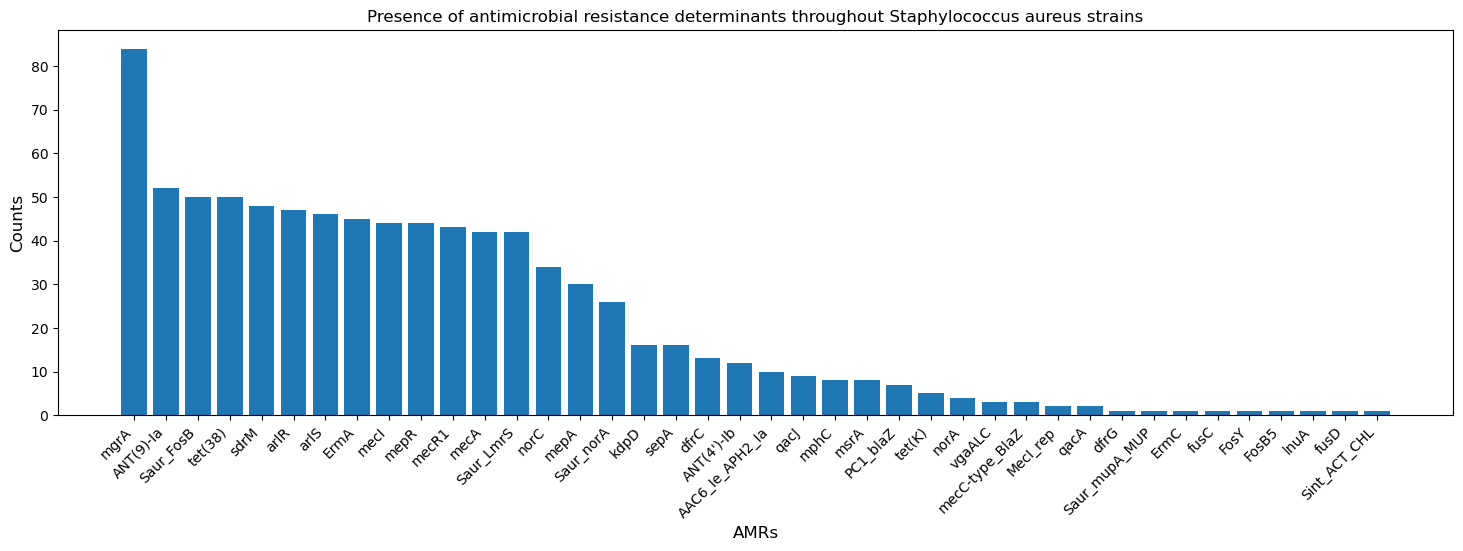

In [89]:
import matplotlib.pyplot as plt

# prepare figure
fig, ax = plt.subplots(figsize=(18,5))

# barplot
ax.bar(amrs_names, amrs_counts)

# title
ax.set_title('Presence of antimicrobial resistance determinants throughout Staphylococcus aureus strains')

# axes labels
ax.set_xlabel('AMRs', fontsize=12)
ax.set_ylabel('Counts', fontsize=12)

# rotate x labels
ax.set_xticks(range(len(amrs_names)))  
ax.set_xticklabels(amrs_names, rotation=45,ha='right')

plt.show()